# Feed-Forward Neural Network Implementation

This notebook implements a simple feed-forward neural network from scratch for educational purposes. We'll build a network that can perform binary classification and visualize how it learns.

## Concepts Covered:

1. **Network Architecture**:
   - Input layer
   - Hidden layer with customizable neurons
   - Output layer (binary classification)
   - Activation functions (ReLU, Sigmoid)

2. **Forward Propagation**:
   - Matrix multiplication
   - Activation function application
   - Output computation

3. **Backpropagation**:
   - Computing gradients
   - Chain rule application
   - Weight updates

4. **Training Process**:
   - Loss calculation
   - Gradient descent
   - Learning rate effects

We'll implement this step-by-step with clear visualizations of:
- Network architecture
- Decision boundary evolution
- Training progress
- Final predictions

The implementation prioritizes clarity over optimization to make the learning process transparent.

In [8]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from typing import List, Tuple, Dict
from IPython.display import clear_output

# Set random seed for reproducibility
np.random.seed(42)

def create_dataset(n_samples: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    """Create a simple binary classification dataset (moons)."""
    X, y = make_moons(n_samples=n_samples, noise=0.2, random_state=42)
    X = StandardScaler().fit_transform(X)  # Scale features
    return X, y

def plot_decision_boundary(X: np.ndarray, y: np.ndarray, model, title: str = "Decision Boundary"):
    """Plot the decision boundary and data points."""
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Make predictions for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

def plot_training_progress(losses: List[float], val_losses: List[float], accuracies: List[float]):
    """Plot training progress: loss and accuracy curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [9]:
class FeedForwardNN:
    """A simple feed-forward neural network implementation."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int = 1):
        """Initialize network architecture.
        
        Args:
            input_size: Number of input features
            hidden_size: Number of neurons in hidden layer
            output_size: Number of output neurons (1 for binary classification)
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
        self.b2 = np.zeros(output_size)
        
    def relu(self, x: np.ndarray) -> np.ndarray:
        """ReLU activation function."""
        return np.maximum(0, x)
    
    def relu_derivative(self, x: np.ndarray) -> np.ndarray:
        """Derivative of ReLU activation function."""
        return (x > 0).astype(float)
    
    def sigmoid(self, x: np.ndarray) -> np.ndarray:
        """Sigmoid activation function."""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def sigmoid_derivative(self, x: np.ndarray) -> np.ndarray:
        """Derivative of sigmoid activation function."""
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def forward(self, X: np.ndarray) -> Tuple[Dict, np.ndarray]:
        """Forward pass through the network.
        
        Args:
            X: Input data of shape (n_samples, input_size)
            
        Returns:
            cache: Intermediate values for backprop
            y_pred: Predictions of shape (n_samples, 1)
        """
        # Hidden layer
        z1 = np.dot(X, self.W1) + self.b1
        a1 = self.relu(z1)
        
        # Output layer
        z2 = np.dot(a1, self.W2) + self.b2
        y_pred = self.sigmoid(z2)
        
        # Cache values for backpropagation
        cache = {
            'X': X,
            'z1': z1,
            'a1': a1,
            'z2': z2,
            'y_pred': y_pred
        }
        
        return cache, y_pred
    
    def backward(self, cache: Dict, y_true: np.ndarray) -> Dict:
        """Backward pass to compute gradients.
        
        Args:
            cache: Values from forward pass
            y_true: True labels
            
        Returns:
            gradients: Computed gradients for all parameters
        """
        m = y_true.shape[0]
        
        # Get cached values
        X = cache['X']
        z1 = cache['z1']
        a1 = cache['a1']
        z2 = cache['z2']
        y_pred = cache['y_pred']
        
        # Output layer gradients
        dz2 = y_pred - y_true.reshape(-1, 1)
        dW2 = (1/m) * np.dot(a1.T, dz2)
        db2 = (1/m) * np.sum(dz2, axis=0)
        
        # Hidden layer gradients
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.relu_derivative(z1)
        dW1 = (1/m) * np.dot(X.T, dz1)
        db1 = (1/m) * np.sum(dz1, axis=0)
        
        return {
            'W1': dW1, 'b1': db1,
            'W2': dW2, 'b2': db2
        }
    
    def update_parameters(self, gradients: Dict, learning_rate: float):
        """Update network parameters using computed gradients."""
        self.W1 -= learning_rate * gradients['W1']
        self.b1 -= learning_rate * gradients['b1']
        self.W2 -= learning_rate * gradients['W2']
        self.b2 -= learning_rate * gradients['b2']
    
    def compute_loss(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        """Compute binary cross-entropy loss."""
        m = y_true.shape[0]
        y_true = y_true.reshape(-1, 1)
        return -np.mean(y_true * np.log(y_pred + 1e-15) + 
                       (1 - y_true) * np.log(1 - y_pred + 1e-15))
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make binary predictions."""
        _, y_pred = self.forward(X)
        return (y_pred >= 0.5).astype(int)
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray, 
             X_val: np.ndarray, y_val: np.ndarray,
             learning_rate: float = 0.1, epochs: int = 100,
             batch_size: int = 32, verbose: bool = True) -> Dict:
        """Train the neural network.
        
        Args:
            X_train, y_train: Training data
            X_val, y_val: Validation data
            learning_rate: Learning rate for gradient descent
            epochs: Number of training epochs
            batch_size: Mini-batch size
            verbose: Whether to print progress
            
        Returns:
            history: Training metrics
        """
        history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }
        
        n_samples = X_train.shape[0]
        
        for epoch in range(epochs):
            # Mini-batch training
            for i in range(0, n_samples, batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                
                # Forward pass
                cache, y_pred = self.forward(X_batch)
                
                # Backward pass
                gradients = self.backward(cache, y_batch)
                
                # Update parameters
                self.update_parameters(gradients, learning_rate)
            
            # Compute metrics
            _, train_pred = self.forward(X_train)
            train_loss = self.compute_loss(train_pred, y_train)
            
            _, val_pred = self.forward(X_val)
            val_loss = self.compute_loss(val_pred, y_val)
            val_acc = np.mean(self.predict(X_val) == y_val)
            
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}")
                print(f"Train Loss: {train_loss:.4f}")
                print(f"Val Loss: {val_loss:.4f}")
                print(f"Val Accuracy: {val_acc:.4f}\n")
                
                # Plot decision boundary every 10 epochs
                clear_output(wait=True)
                plot_decision_boundary(X_train, y_train, self,
                                    f"Decision Boundary - Epoch {epoch + 1}")
                
        return history

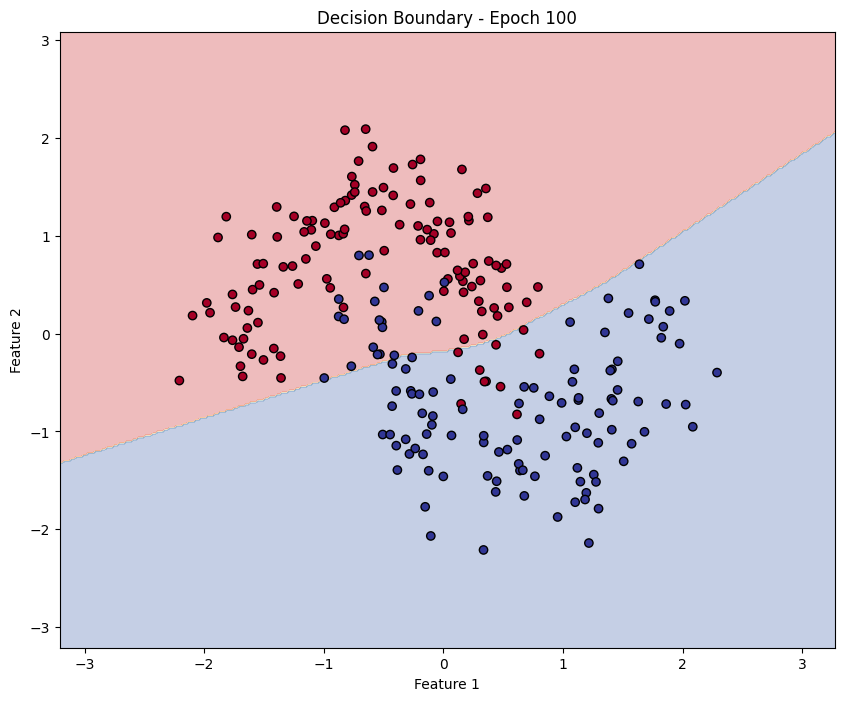

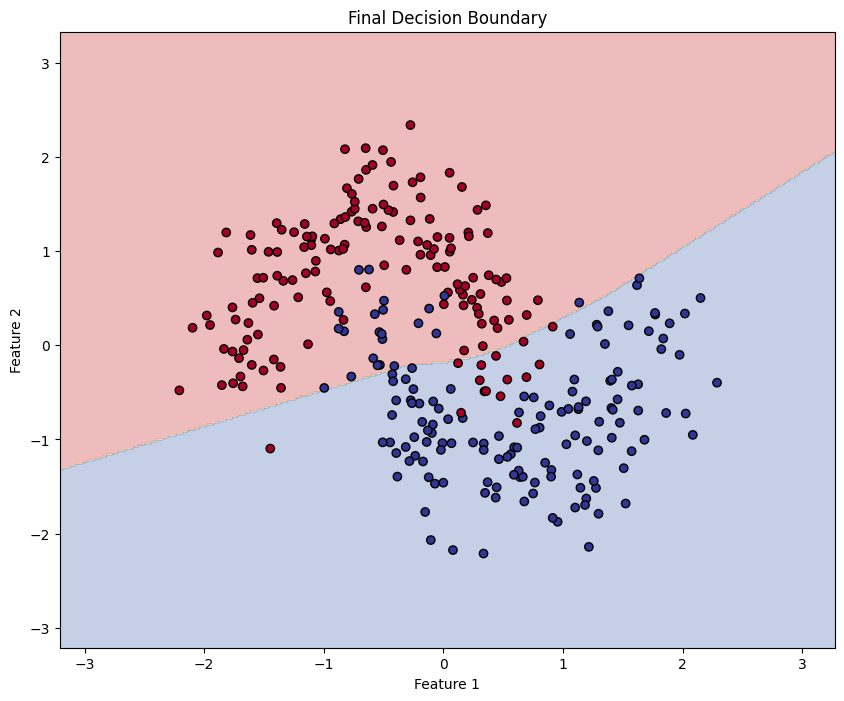

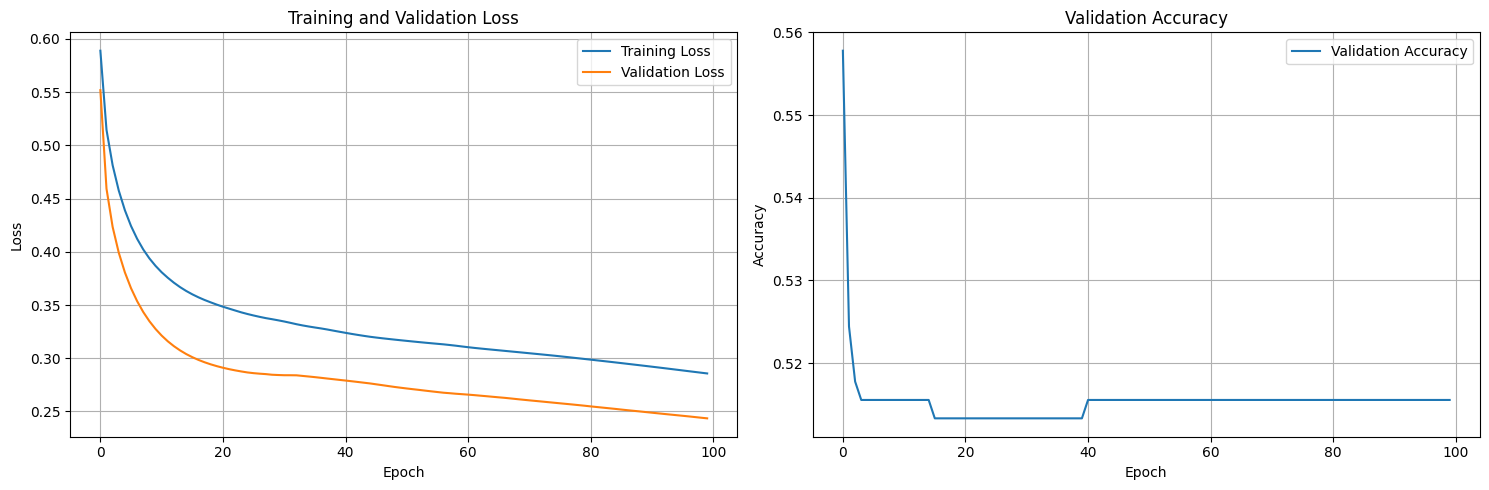


Final Validation Accuracy: 0.5156


In [10]:
# Create dataset
X, y = create_dataset(n_samples=300)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Show the dataset
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1])
plt.title('Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Create and train the network
model = FeedForwardNN(input_size=2, hidden_size=10, output_size=1)

# Train the model
history = model.train(
    X_train, y_train,
    X_val, y_val,
    learning_rate=0.1,
    epochs=100,
    batch_size=32,
    verbose=True
)

# Plot final decision boundary
plot_decision_boundary(X, y, model, "Final Decision Boundary")

# Plot training progress
plot_training_progress(
    history['train_loss'],
    history['val_loss'],
    history['val_acc']
)

# Print final validation accuracy
final_accuracy = history['val_acc'][-1]
print(f"\nFinal Validation Accuracy: {final_accuracy:.4f}")

## Understanding the Implementation and Results

### Network Architecture
Our implementation uses a simple architecture:
- Input Layer: 2 neurons (for our 2D features)
- Hidden Layer: 10 neurons with ReLU activation
- Output Layer: 1 neuron with sigmoid activation

### Key Components

1. **Forward Propagation**:
   - Input → Hidden Layer: `z1 = X·W1 + b1`, then ReLU
   - Hidden → Output: `z2 = a1·W2 + b2`, then sigmoid
   - ReLU helps with non-linearity
   - Sigmoid squashes output to [0,1] for binary classification

2. **Backpropagation**:
   - Compute gradients from output to input
   - Use chain rule to propagate errors
   - Update weights and biases using gradients

3. **Training Process**:
   - Mini-batch gradient descent
   - Binary cross-entropy loss
   - Learning rate of 0.1
   - 100 epochs

### Visualization Explanation

1. **Decision Boundary Plot**:
   - Shows how the network divides the feature space
   - Blue/Red regions show predicted classes
   - Points show actual data samples
   - Boundary becomes more complex as the network learns

2. **Training Curves**:
   - Loss decreases as network learns
   - Validation accuracy increases
   - Gaps between train/val loss indicate overfitting

### Tips for Modification

Try experimenting with:
1. Network architecture (more/fewer hidden neurons)
2. Learning rate
3. Batch size
4. Number of epochs
5. Different activation functions
6. Additional hidden layers

### Common Issues and Solutions

1. **Vanishing Gradients**:
   - ReLU helps prevent this
   - Proper weight initialization used

2. **Overfitting**:
   - Add regularization
   - Adjust network size
   - Use dropout (not implemented here for simplicity)

3. **Poor Convergence**:
   - Adjust learning rate
   - Change batch size
   - Normalize inputs (done here with StandardScaler)